In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import os, glob, shutil, math, time
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import History, CSVLogger, EarlyStopping

########################################################################
# This section rescales the data. For most ML models, we want to       #
# rescale so that we are analyzing data consistently (scale invariant) #
########################################################################
def data_rescale(scaled_dat,train_mean,train_var):
    d = np.shape(train_mean)[0]
    #print('unnormalizing with number of dimensions = ' +str(d))
    dat = (np.multiply(scaled_dat,np.sqrt(train_var))) + train_mean.T
    return(dat)
############################################################################
# Opposite to the above, normalizes the data based on some training values #
############################################################################
def data_normalize(data,train_mean,train_var):
    d = np.shape(train_mean)[0]
    print('normalizing with number of dimensions = ' +str(d))
    scaled_dat = np.divide((data - train_mean.T),np.sqrt(train_var),)
    return(scaled_dat)
    


Using TensorFlow backend.


In [2]:
data = pd.read_csv("/Users/adityanandy/BGU-workshop/Data/QM9/mu-qm-file.csv")

In [3]:
# forbid_names = ['comb_2_0']
# for forb in forbid_names:
#     data  =  data.loc[data['Unnamed: 0']  != forb]
print(data['u0'])

0        -0.631066
1        -0.441207
2        -0.339577
3        -0.614337
4        -0.480982
5        -0.571716
6        -1.068970
7        -0.766693
8        -1.068141
9        -0.939926
10       -1.028397
11       -0.864757
12       -1.509975
13       -1.212970
14       -1.200600
15       -1.282844
16       -0.983347
17       -1.481807
18       -1.315953
19       -1.141296
20       -1.952528
21       -1.660153
22       -1.072212
23       -0.933308
24       -0.787267
25       -1.019190
26       -0.879601
27       -0.975537
28       -1.520215
29       -1.508619
            ...   
133855   -2.735116
133856   -2.984682
133857   -2.727081
133858   -2.778933
133859   -2.691604
133860   -2.959853
133861   -2.927256
133862   -3.166465
133863   -2.906811
133864   -2.714148
133865   -2.620268
133866   -2.984697
133867   -3.277457
133868   -2.973493
133869   -2.682754
133870   -2.695881
133871   -2.780896
133872   -3.061731
133873   -2.757616
133874   -2.755437
133875   -2.871581
133876   -3.

In [4]:
## seed 
np.random.seed(4)
# get random partition
msk = np.random.rand(np.shape(data)[0]) < 0.20 

# test and train split
first_train_data = data[msk]
test_data = data[~msk]

# train and val split
val_msk = np.random.rand(np.shape(first_train_data)[0]) < 0.80
train_data = first_train_data[val_msk]
val_data = first_train_data[~val_msk]

In [5]:
# get 
feature_names=[]
for ft in data.columns:
    if ft.find('u0') ==-1  and ft.find('runs') ==-1 and ft.find('mu') ==-1:
            feature_names.append(ft)
print(feature_names)

['f-chi-0-all', 'f-chi-1-all', 'f-chi-2-all', 'f-chi-3-all', 'f-Z-0-all', 'f-Z-1-all', 'f-Z-2-all', 'f-Z-3-all', 'f-I-0-all', 'f-I-1-all', 'f-I-2-all', 'f-I-3-all', 'f-T-0-all', 'f-T-1-all', 'f-T-2-all', 'f-T-3-all', 'f-S-0-all', 'f-S-1-all', 'f-S-2-all', 'f-S-3-all']


In [9]:
variable = 'mu'
train_data_y = train_data[variable]
test_data_y = test_data[variable]
val_data_y = val_data[variable]
# xvales
train_data_x = train_data[feature_names].values
test_data_x = test_data[feature_names].values
val_data_x = val_data[feature_names].values
## data generation
m = np.shape(train_data_x)[0]
d = np.shape(train_data_x)[1]
p = 1
# normalization
train_var_x = np.var(train_data_x,0)
train_mean_x = np.mean(train_data_x,0).reshape(d,1).squeeze()
train_var_y = np.var(train_data_y,0).reshape(1)
train_mean_y = np.mean(train_data_y,0).reshape(1)
# scale
scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y)
scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)
scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y)
scaled_val_data_x = data_normalize(val_data_x,train_mean_x,train_var_x)
scaled_val_data_y = data_normalize(val_data_y,train_mean_y,train_var_y)

normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1


In [10]:
def prepare_architecture(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=["mae"])
    return model

def train_model(model, x_train, y_train, x_val, y_val,epochs, verbose=True):
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100, verbose=1, mode='auto')
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=50, validation_data=(x_val, y_val),
            callbacks=[earlystop], verbose=verbose)
    return model, history

In [11]:
layers = [Dense(300, input_dim=20, kernel_initializer='normal', activation='relu',kernel_regularizer = l2(1e-06)),
          Dropout(0.10, noise_shape=None, seed=None),
          Dense(300, kernel_initializer='normal', activation='relu', kernel_regularizer = l2(1e-06)),
          Dropout(0.10, noise_shape=None, seed=None), 
          Dense(1,activation='linear')]
model = prepare_architecture(layers)
trained_model, history = train_model(model,scaled_train_data_x,scaled_train_data_y,
                                            scaled_val_data_x,scaled_val_data_y,2000)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               6300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 96,901
Trainable params: 96,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 21677 samples, validate on 5375 samples
Epoch 1/2000
21677/21677 [==============================] - 2s - loss: 0.7198 - mean

21677/21677 [==============================] - 2s - loss: 0.4786 - mean_absolute_error: 0.4997 - val_loss: 0.4824 - val_mean_absolute_error: 0.5058
Epoch 46/2000
21677/21677 [==============================] - 2s - loss: 0.4696 - mean_absolute_error: 0.4920 - val_loss: 0.4853 - val_mean_absolute_error: 0.4977
Epoch 47/2000
21677/21677 [==============================] - 2s - loss: 0.4795 - mean_absolute_error: 0.4947 - val_loss: 0.5027 - val_mean_absolute_error: 0.5074
Epoch 48/2000
21677/21677 [==============================] - 2s - loss: 0.4630 - mean_absolute_error: 0.4879 - val_loss: 0.4703 - val_mean_absolute_error: 0.4943
Epoch 49/2000
21677/21677 [==============================] - 2s - loss: 0.4760 - mean_absolute_error: 0.4927 - val_loss: 0.4784 - val_mean_absolute_error: 0.4993
Epoch 50/2000
21677/21677 [==============================] - 2s - loss: 0.4637 - mean_absolute_error: 0.4903 - val_loss: 0.4897 - val_mean_absolute_error: 0.5007
Epoch 51/2000
21677/21677 [===============

21677/21677 [==============================] - 3s - loss: 0.4083 - mean_absolute_error: 0.4592 - val_loss: 0.4789 - val_mean_absolute_error: 0.4932
Epoch 96/2000
21677/21677 [==============================] - 2s - loss: 0.4209 - mean_absolute_error: 0.4616 - val_loss: 0.4726 - val_mean_absolute_error: 0.4887
Epoch 97/2000
21677/21677 [==============================] - 2s - loss: 0.4111 - mean_absolute_error: 0.4587 - val_loss: 0.5212 - val_mean_absolute_error: 0.5139
Epoch 98/2000
21677/21677 [==============================] - 3s - loss: 0.4058 - mean_absolute_error: 0.4567 - val_loss: 0.4880 - val_mean_absolute_error: 0.4967
Epoch 99/2000
21677/21677 [==============================] - 3s - loss: 0.4087 - mean_absolute_error: 0.4578 - val_loss: 0.4846 - val_mean_absolute_error: 0.5032
Epoch 100/2000
21677/21677 [==============================] - 3s - loss: 0.4064 - mean_absolute_error: 0.4575 - val_loss: 0.4738 - val_mean_absolute_error: 0.4908
Epoch 101/2000
21677/21677 [=============

21677/21677 [==============================] - 2s - loss: 0.3758 - mean_absolute_error: 0.4363 - val_loss: 0.4757 - val_mean_absolute_error: 0.4908
Epoch 146/2000
21677/21677 [==============================] - 2s - loss: 0.3697 - mean_absolute_error: 0.4343 - val_loss: 0.4803 - val_mean_absolute_error: 0.4985
Epoch 147/2000
21677/21677 [==============================] - 2s - loss: 0.3720 - mean_absolute_error: 0.4359 - val_loss: 0.4779 - val_mean_absolute_error: 0.4951
Epoch 148/2000
21677/21677 [==============================] - 2s - loss: 0.3683 - mean_absolute_error: 0.4333 - val_loss: 0.4693 - val_mean_absolute_error: 0.4849
Epoch 149/2000
21677/21677 [==============================] - 2s - loss: 0.3662 - mean_absolute_error: 0.4315 - val_loss: 0.4753 - val_mean_absolute_error: 0.4908
Epoch 150/2000
21677/21677 [==============================] - 2s - loss: 0.3685 - mean_absolute_error: 0.4341 - val_loss: 0.4763 - val_mean_absolute_error: 0.4921
Epoch 151/2000
21677/21677 [=========

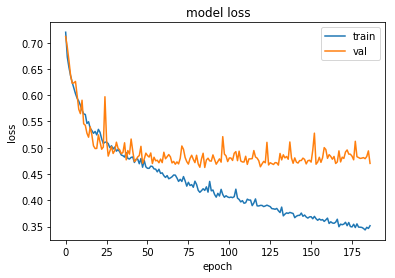

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Text(0,0.5,'pred')

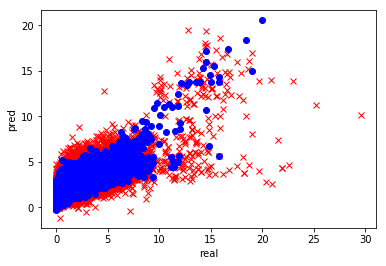

In [13]:
pred_train = data_rescale(model.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
pred_test = data_rescale(model.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
plt.plot(real_test,pred_test,'rx')
plt.plot(real_train,pred_train,'bo')
plt.xlabel('real')
plt.ylabel('pred')